# Previsor de Falso Alarme para Incêndios
Previsor que permite detetar se uma alerta de incêndio é um falso alarme com base na hora, data, local entre outras variáveis.
De momento encontra-se com 85% de accuracy, embora seja possível melhorar este valor com outros algoritmos ou adicionar/retirar variáveis.

# Descrição do Dataset
Variáveis:
- Ano: Desde 1895 até 2015
- Códigos da proteção civil: Permite relacionar ocorrências com outras variáveis. Não utilizadas aqui.
- Zona Nut / Distrito / Concelho / Freguesia / Local : Orientação geográfica
- Datas importantes como do primeiro alerta, primeria intervenção e extinção.
- Áreas ardidas : Dados sobre a tipologia do terreno ardido.
- Tipo de incêndio : Permite saber algumas especificações sobre a origem do incêndio.
- Entre outras.
São 38 no total.


# Imports Necessários:

  - numpy
  - pandas
  - sklearn
  - matplotlib
  - seaborn
  - time
 
# Nota de Agradecimento:
  Agradeço ao projecto central de dados por este fantástico dataset.
# Links Importantes:
  - Dataset utilizado: http://centraldedados.pt/incendios/ 
  
  - Github do projecto: https://github.com/centraldedados/incendios

# Código

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import NearestNeighbors
from sklearn import neighbors
from sklearn import svm
from sklearn import tree
from sklearn.naive_bayes import GaussianNB

In [2]:
files = ['incendios2015.csv', 'incendios2014.csv', 'incendios2013.csv', 'incendios2012.csv']

data=pd.concat([pd.read_csv(f) for f in files], ignore_index=True,sort=False)
#data=pd.read_csv('incendios2015.csv',encoding='iso-8859-1')
data.head()

,ano,codigo_sgif,codigo_anpc,tipo,distrito,concelho,freguesia,local,ine,x,...,fogacho,incendio,agricola,perimetro,aps,causa,tipo_causa,regiao_prof,ugf,reacendimentos
0,2015,DM315252,2.015160e+12,Florestal,Viana do Castelo,Ponte de Lima,Serdedelo,VALE DE TROVELA (SERDEDELO),160746.0,167814,...,0,1,0,NaN,NaN,122.0,Negligente,Entre Douro e Minho,Alto Minho,NaN
1,2015,DM215305,2.015130e+12,Florestal,Porto,Marco de Canaveses,Vila Boa de Quires,LUGAR DO FOFO,130731.0,193731,...,0,1,0,NaN,NaN,122.0,Negligente,Entre Douro e Minho,Tâmega,NaN
2,2015,DM415293,2.015030e+12,Florestal,Braga,Vila Verde,Lage,RUA PROF ABEL MADEIRA,31323.0,172162,...,1,0,0,NaN,NaN,60.0,Desconhecida,Entre Douro e Minho,Baixo Minho,NaN
3,2015,DM315261,2.015160e+12,Falso Alarme,Viana do Castelo,Ponte de Lima,Boalhosa,J. DEPOSITOS DE AGUA (BOALHOSA),160709.0,171291,...,0,0,0,NaN,NaN,630.0,Desconhecida,Entre Douro e Minho,Alto Minho,NaN
4,2015,BL115321,2.015180e+12,Agrícola,Viseu,Castro Daire,Castro Daire,Farejinhas - Bº das Queirós,180304.0,217299,...,1,0,0,NaN,NaN,630.0,Desconhecida,Beira Litoral,Dão Lafões,NaN


In [3]:
print(data.columns)
data.shape

Index(['ano', 'codigo_sgif', 'codigo_anpc', 'tipo', 'distrito', 'concelho',
       'freguesia', 'local', 'ine', 'x', 'y', 'lat', 'lon', 'data_alerta',
       'hora_alerta', 'data_extincao', 'hora_extincao',
       'data_primeira_intervencao', 'hora_primeira_intervencao',
       'fonte_alerta', 'nut', 'area_povoamento', 'area_mato', 'area_agricola',
       'area_pov_mato', 'area_total', 'reacendimento', 'queimada',
       'falso_alarme', 'fogacho', 'incendio', 'agricola', 'perimetro', 'aps',
       'causa', 'tipo_causa', 'regiao_prof', 'ugf', 'reacendimentos'],
      dtype='object')


(92674, 39)

In [4]:
print(list(data.isnull().any()))

[False, False, True, False, False, False, False, True, True, False, False, True, True, False, False, True, True, True, True, True, False, False, False, False, False, False, True, False, False, False, False, False, True, True, True, True, True, True, True]


In [5]:
col = [ 'tipo', 'distrito', 'concelho',
       'freguesia', 'local', 'data_alerta','x','y',
    'area_povoamento', 'area_mato', 'area_agricola',
       'area_pov_mato', 'area_total', 'queimada',
       'falso_alarme', 'fogacho', 'incendio', 'agricola',
       'causa']
train = data[col]
train=train.copy()
train.head()

,tipo,distrito,concelho,freguesia,local,data_alerta,x,y,area_povoamento,area_mato,area_agricola,area_pov_mato,area_total,queimada,falso_alarme,fogacho,incendio,agricola,causa
0,Florestal,Viana do Castelo,Ponte de Lima,Serdedelo,VALE DE TROVELA (SERDEDELO),2015-03-24,167814,530896,2.50,0.00,0.0,2.50,2.50,0,0,0,1,0,122.0
1,Florestal,Porto,Marco de Canaveses,Vila Boa de Quires,LUGAR DO FOFO,2015-03-24,193731,471896,0.00,1.35,0.0,1.35,1.35,0,0,0,1,0,122.0
2,Florestal,Braga,Vila Verde,Lage,RUA PROF ABEL MADEIRA,2015-03-24,172162,517209,0.26,0.00,0.0,0.26,0.26,0,0,1,0,0,60.0
3,Falso Alarme,Viana do Castelo,Ponte de Lima,Boalhosa,J. DEPOSITOS DE AGUA (BOALHOSA),2015-03-24,171291,529577,0.00,0.00,0.0,0.00,0.00,0,1,0,0,0,630.0
4,Agrícola,Viseu,Castro Daire,Castro Daire,Farejinhas - Bº das Queirós,2015-03-24,217299,436999,0.00,0.05,0.0,0.05,0.05,0,0,1,0,0,630.0


In [6]:
features =['tipo', 'distrito', 'concelho',
       'freguesia','local']
for feature in features:
        train[feature]=  train[feature].fillna('Desconhecido')
        le = preprocessing.LabelEncoder()
        le = le.fit(train[feature])
        train[feature] = le.transform(train[feature])

train['data_alerta']=train['data_alerta'].str.replace('-','')

# Alguns gráficos para melhor vizualizar os dados

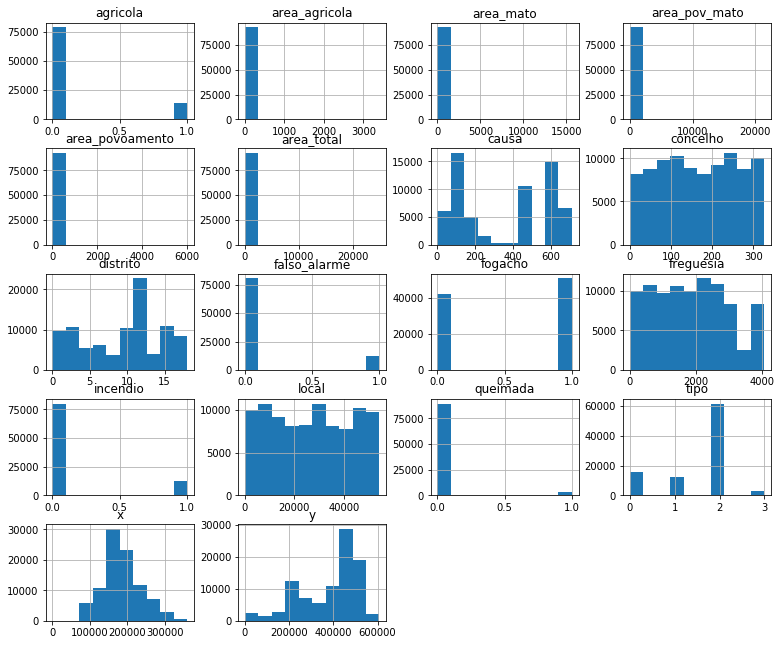

In [8]:
train.hist(figsize=(13, 11))

plt.show()


# Encontrar possíveis relações

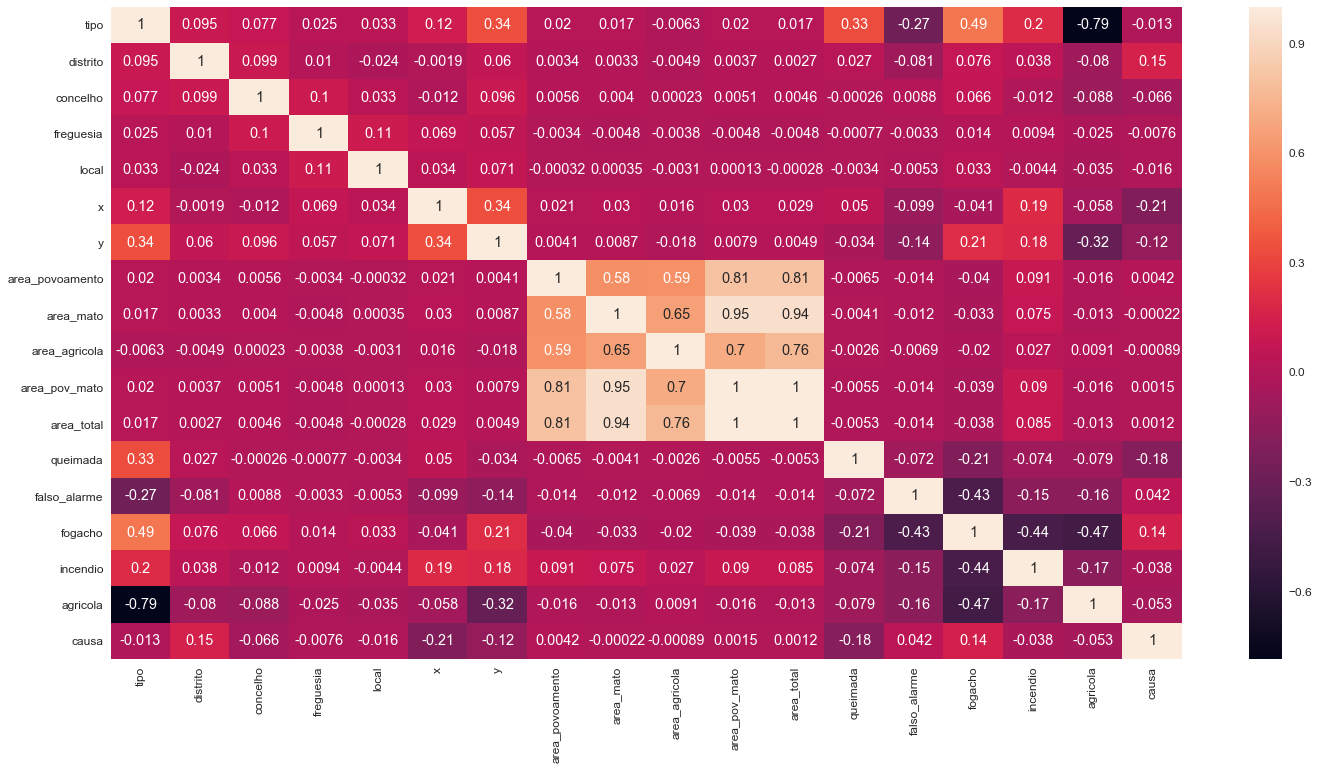

In [21]:
plt.figure(figsize=(24, 12))
corr = train.corr()
sb.heatmap(corr, annot=True)
plt.show()

# Escolha das amostras para utilizar nos algoritmos

#### X : Variáveis que possam ser dadas durante a chamada de alerta: Hora, Data, Local e Coordenadas.

#### Y : Variável a testar, se a chamada é falso alarme ou não.

In [10]:
X = train.drop(['tipo','area_povoamento', 'area_mato', 'area_agricola',
       'area_pov_mato', 'area_total', 'queimada',
       'falso_alarme', 'fogacho', 'incendio', 'agricola',
       'causa'],axis=1)
y = train['falso_alarme']
X=X.fillna(X.mean())
X.shape

(92674, 7)

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=23)

Accuracy --  86.8099615866028


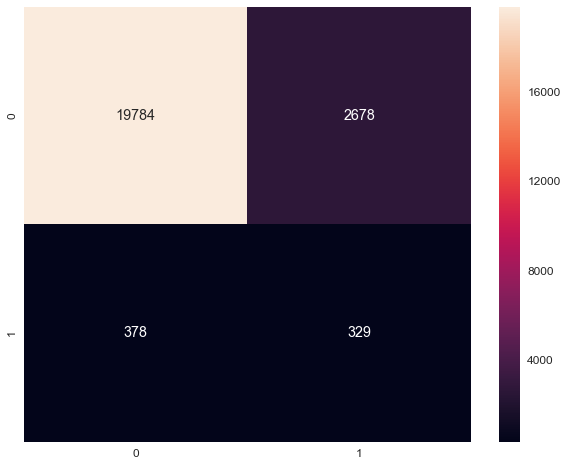

In [12]:
from sklearn.ensemble import RandomForestClassifier
clf =RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=20, max_features='log2', max_leaf_nodes=None,
            min_samples_leaf=2, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=9, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
clf.fit(X_train, y_train)


#prediction
y_pred = clf.predict(X_test)

#score
print("Accuracy -- ", clf.score(X_test, y_test)*100)

#confusion
cm = confusion_matrix(y_pred, y_test)
plt.figure(figsize=(10, 8))
sb.set(font_scale=1.2)
sb.heatmap(cm, annot=True, fmt='g')
plt.show()